# Setting up environment

In [ ]:
!mkdir val2017
!gsutil -m rsync gs://images.cocodataset.org/val2017 val2017

In [ ]:
!mkdir coco
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d coco

In [ ]:
# !pip install tensorflow-gpu==2.0 lime
!pip install lime
!pip install -U setuptools
!pip install -U wheel
!make install -C cocoapi/PythonAPI # NOT WORKING

In [ ]:
!mkdir figures

In [1]:
import requests as r
from io import BytesIO
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import numpy as np
from math import floor

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

from tensorflow.keras.applications import inception_v3 as inc_net

import keras
print(f"Keras {keras.__version__}")
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image

import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm, BaseWrapper

from sklearn.metrics import confusion_matrix 
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, inverse_gaussian_gradient, morphological_geodesic_active_contour
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.measure import label

import scipy.ndimage as ndi

Tensorflow 1.15.0
Keras 2.2.5


Using TensorFlow backend.


In [2]:
inet_model = inc_net.InceptionV3()
explainer = lime_image.LimeImageExplainer()
root = ET.fromstring(r.get("http://www.image-net.org/api/xml/structure_released.xml").text)
imagenet_classes = eval(r.get("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json").text)

W0103 13:06:58.540971  5232 deprecation.py:506] From c:\users\javie\workspace\python\tf-gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Explanator wrapper

In [3]:
class CustomSegmentationAlgorithm(BaseWrapper):
    """ https://github.com/marcotcr/lime/blob/master/lime/wrappers/scikit_image.py
        Modification to include watershed
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type
        if (self.algo_type == 'quickshift'):
            BaseWrapper.__init__(self, quickshift, **target_params)
            kwargs = self.filter_params(quickshift)
            self.set_params(**kwargs)
        elif (self.algo_type == 'felzenszwalb'):
            BaseWrapper.__init__(self, felzenszwalb, **target_params)
            kwargs = self.filter_params(felzenszwalb)
            self.set_params(**kwargs)
        elif (self.algo_type == 'slic'):
            BaseWrapper.__init__(self, slic, **target_params)
            kwargs = self.filter_params(slic)
            self.set_params(**kwargs)
        elif (self.algo_type == 'watershed'):
            BaseWrapper.__init__(self, watershed, **target_params)
            kwargs = self.filter_params(watershed)
            self.set_params(**kwargs)

    def __call__(self, *args):
        img = args[0] if self.algo_type != 'watershed' else sobel(rgb2gray(args[0]))
        return self.target_fn(args[0], **self.target_params)

In [14]:
class Explanator:
  def __init__(self, inet_model=None, explainer=None, root=None, class_mapping=None, imagenet_classes=None):

    self.inet_model = inet_model if inet_model else inc_net.InceptionV3()
    self.explainer = explainer if explainer else lime_image.LimeImageExplainer()
    self.root = root if root else ET.fromstring(r.get("http://www.image-net.org/api/xml/structure_released.xml").text)
    self.imagenet_classes = imagenet_classes if imagenet_classes else eval(r.get("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json").text)
    
    if class_mapping:
      self.class_mapping = class_mapping
    else:
      self.class_mapping = {
          "person": {
              "wnid": "n00007846",
          },
          "bicycle": {
              "wnid": "n02834778"
          },
          "car": {
              "wnid": "n02958343"
          },
          "cat": {
              "wnid": "n02121808"
          }
      }

    self.wnid_mapping = {}
    self.fetch_mappings()

  def get_synset(self, wnid):
    for i in self.root[1].iter("synset"):
      if i.get("wnid") == wnid:
        return i

  def fetch_mappings(self):
    for i, v in self.class_mapping.items():
      # load sub_wnids
      synset = self.get_synset(v["wnid"])
      self.class_mapping[i]["sub_wnids"] = self.get_sub_wnids(synset)
      #load wnid_mapping
      for wnid in self.class_mapping[i]["sub_wnids"]+[v["wnid"]]:
        self.wnid_mapping[wnid] = i

  def download_and_preprocess(self, url):
    response = r.get(url)
    im = Image.open(BytesIO(response.content))
    im = im.resize((299, 299))
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = inc_net.preprocess_input(x)
    return im, x

  def predict(self, x):
    preds = self.inet_model.predict(x)
    preds_decoded = decode_predictions(preds)[0]
    return preds_decoded

  def get_segmentation(self, anns, img_md):
    scaler_v = np.vectorize(self.scaler, excluded=["S", "cx"])
    
    polygons = []
    segs = []
    color = []
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    
    for seg in anns[0]["segmentation"]:
      poly, rescaled_seg = self.rescale_poly(seg, scaler_v, img_md["width"], img_md["height"])
      polygons.append(poly)  
      segs.append(rescaled_seg)
      color.append(c)
    return color, polygons, segs

  def explain(self, img, img_md, segmentation_fns, top_labels=5, num_samples=1000):
    annIds = coco.getAnnIds(imgIds=img_md['id'], catIds=[], iscrowd=None)
    anns = coco.loadAnns(annIds)
    color, polygons, segs = self.get_segmentation(anns, img_md)
    img_shape = (img.shape[0], img.shape[1])
    
    # poly mask: ground-truth
    img_new = Image.new('L', img_shape, 0)
    ImageDraw.Draw(img_new).polygon(segs[0].tolist(), outline=1, fill=1)
    poly_mask = np.array(img_new)
    
    output = {}
    for segmentation_fn in segmentation_fns:
      explanation = self.explainer.explain_instance(img, self.inet_model.predict, top_labels=top_labels, hide_color=0, num_samples=num_samples, segmentation_fn=CustomSegmentationAlgorithm(segmentation_fn))
      union_mask = np.zeros(img_shape, dtype=int)
      output[segmentation_fn] = {}
        
      for i in explanation.top_labels:
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, hide_rest=True)
        classes = self.imagenet_classes[str(i)]
        union_mask = mask if union_mask is None else np.bitwise_or(union_mask, mask)
        
        iou, dice, pixel_acc = self.evaluate_segmentation(mask, poly_mask)
        print(f"Labels {self.imagenet_classes[str(i)]} evaluation")
        print(f"IOU: {iou}")
        print(f"DICE: {dice}")
        print(f"Pixel acc: {pixel_acc}")
        
        # to-do: Subplots
        self.plot_and_save_segmentation(img, mask, polygons, color, segmentation_fn, classes)
        output[segmentation_fn][str(classes)] = { 'mask': mask, 'iou': iou, 'dice': dice, 'pixel_acc': pixel_acc }
      
      # evaluate union masks per segmentation
      iou, dice, pixel_acc = self.evaluate_segmentation(union_mask, poly_mask)
      print(f"Segmentation {segmentation_fn} union mask evaluation:")
      print(f"IOU: {iou}")
      print(f"DICE: {dice}")
      print(f"Pixel acc: {pixel_acc}")
    
      joined_classes = "-".join(np.concatenate([self.imagenet_classes[str(i)] for i in explanation.top_labels], axis=0))
      self.plot_and_save_segmentation(img, union_mask, polygons, color, segmentation_fn, joined_classes)
      output[segmentation_fn]["union"] = { 'mask': union_mask, 'iou': iou, 'dice': dice, 'pixel_acc': pixel_acc }
      
    return output

  def plot_and_save_segmentation(self, img, mask, polygons, color, segmentation_fn, classes):
    plt.figure(figsize=(10,10))
    plt.imshow(mark_boundaries(img / 2 + 0.5, mask))
    plt.title(segmentation_fn + " / " + str(classes))

    ax = plt.gca()
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)
    plt.axis('off')
    plt.show()
    plt.savefig("figures/test.png") # to-do: remove line
    plt.savefig("figures/" + segmentation_fn + "_" + classes[1] + ".png")
    
  @staticmethod
  def scaler(x, S, cx):
    return (  S * (x - cx) ) + cx

  @staticmethod
  def rescale_poly(poly, scaler_v, width, height):
    # poly: [x1,y1,x2,y2,...]
    poly = np.array(poly).reshape((int(len(poly)/2), 2))
    poly[:,0] = scaler_v(poly[:,0], S=299/width, cx=0)
    poly[:,1] = scaler_v(poly[:,1], S=299/height, cx=0)
    return Polygon(poly), poly.flatten()

  @staticmethod
  def evaluate_segmentation(y_pred, y_true):
    # essential metrics: Pixel accuracy, Intersection-Over-Union (Jaccard index) and Dice coeff (f1 score)
    # intro: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
    
    assert y_pred.shape == y_true.shape, 'Input masks should be same shape'
    
    vec_y_pred = y_pred.flatten()
    vec_y_true = y_true.flatten()
    
    # confusion matrix
    current = confusion_matrix(vec_y_true, vec_y_pred, labels=[0, 1])
    tn, fp, fn, tp = current.ravel()
    
    # metrics
    iou = tp / (tp + fp + fn)
    dice = 2*tp / (2*tp + fp + fn)
    pixel_acc = (fp + fn) / (tp + tn + fp + fn)
    
    # IOU alternatives

    # using coco_mask: NOT WORKING
    # patch -> asfortranarray: https://github.com/cocodataset/cocoapi/issues/91
#     inter = np.bitwise_and(vec_y_pred, vec_y_true)
#     enc_inter = coco_mask.encode(inter)
#     enc_union = coco_mask.encode(np.bitwise_or(vec_y_pred, vec_y_true))
#     iou_coco = coco_mask.area(enc_inter) / coco_mask.area(enc_union)
#     iou_coco = coco_mask.iou(enc_y_pred, enc_y_true, 0)
#     print(f"IOU COCO: {iou_coco}")

    # using tf.metrics.mean_iou: NOT WORKING
#     with tf.Session() as sess: 
#       ypredT = tf.constant(np.argmax(vec_y_pred, axis=-1))
#       ytrueT = tf.constant(np.argmax(vec_y_true, axis=-1))
#       iou, conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=2)
#       sess.run(tf.local_variables_initializer())
#       sess.run([conf_mat])
#       miou = sess.run(iou)
#       print(f"MIOU: {miou}")

    # using tf.keras.metrics.MeanIoU: NOT WORKING
#     with tf.Session() as sess:
#       m = tf.keras.metrics.MeanIoU(num_classes=2)
#       m.update_state(vec_y_true, vec_y_pred)
#       res_tensor = m.result()
#       sess.run(tf.local_variables_initializer())
#       iou_keras = sess.run(res_tensor)
#       print(f"IOU KERAS: {iou_keras}")

    return iou, dice, pixel_acc

  @staticmethod
  def get_sub_wnids(synset):
    sub_wnids = []
    for i in synset.iter("synset"):
      sub_wnids.append(i.get("wnid"))
    return sub_wnids

  @staticmethod
  def plot_segmentations(img, segmentation_fns):
    n_cols = 2
    n_rows = floor(len(segmentation_fns) / n_cols)
    if len(segmentation_fns) % n_cols > 0:
      n_rows += 1

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10), sharex=True, sharey=True)
    cnt = -1

    for segmentation_fn, params in segmentation_fns.items():
      cnt += 1

      # eval segmentation
      if segmentation_fn == 'canny':
        img_gray = rgb2gray(img)
        edges = canny(img_gray, sigma=params['sigma'])
        fill_edges = ndi.binary_fill_holes(edges)
        segments = ndi.label(remove_small_objects(fill_edges, params['min_size']))[0]
        print(f"{segmentation_fn}(img, sigma={params['sigma']}) - min_size=params['min_size']")
      elif segmentation_fn == 'morphological_geodesic_active_contour':
        img_gray = rgb2gray(img)
        img_float = img_as_float(img_gray)
        gradient = inverse_gaussian_gradient(img_float)
        init_ls = np.zeros(img_gray.shape, dtype=np.int8)
        init_ls[10:-10, 10:-10] = 1
        params['init_ls'] = init_ls
        raw_segments = morphological_geodesic_active_contour(gradient, iterations=params['iterations'],
                        init_level_set=init_ls, smoothing=params['smoothing'], balloon=params['balloon'],
                        threshold=params['threshold'])
        segments = label(raw_segments)
      else:
        segments = Explanator.get_segments(img, params, segmentation_fn)
        
      print(f"{segmentation_fn} number of segments: {len(np.unique(segments))}")

      # plot
      r = floor(cnt / n_cols)
      c = cnt % n_cols
      ax[r, c].imshow(mark_boundaries(img, segments))
      ax[r, c].set_title(segmentation_fn)

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

  @staticmethod
  def get_segments(img, params, segmentation_fn):
    img_param = img if segmentation_fn != 'watershed' else sobel(rgb2gray(img))
    str_params = ', '.join([f"{k}={v}" for k,v in params.items()])
    function = segmentation_fn + '(img_param, ' + str_params + ')'
    print(function)
    segments = eval(function)
    return segments

# COCO


In [5]:
%matplotlib inline
from pycocotools.coco import COCO
import pycocotools.mask as coco_mask
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [6]:
dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


# Test

In [15]:
# explanator
model = Explanator(inet_model=inet_model, explainer=explainer, root=root, imagenet_classes=imagenet_classes)

# images
# im, x = model.download_and_preprocess("http://farm7.staticflickr.com/6012/5930972911_f491d3f29a_z.jpg")
# im, x = model.download_and_preprocess("http://farm1.staticflickr.com/14/88446581_f02412ae00_z.jpg")
# im, x = model.download_and_preprocess("http://images.cocodataset.org/val2017/000000106389.jpg")
# plt.figure(figsize=(10, 10))
# plt.imshow(im)

In [8]:
# coco images
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
indoor furniture appliance sports outdoor electronic kitchen accessory vehicle food person animal


In [9]:
catIds = coco.getCatIds(catNms=['cat']);
imgIds = coco.getImgIds(catIds=catIds);
print(f"Coco images: {len(imgIds)}")

Coco images: 184


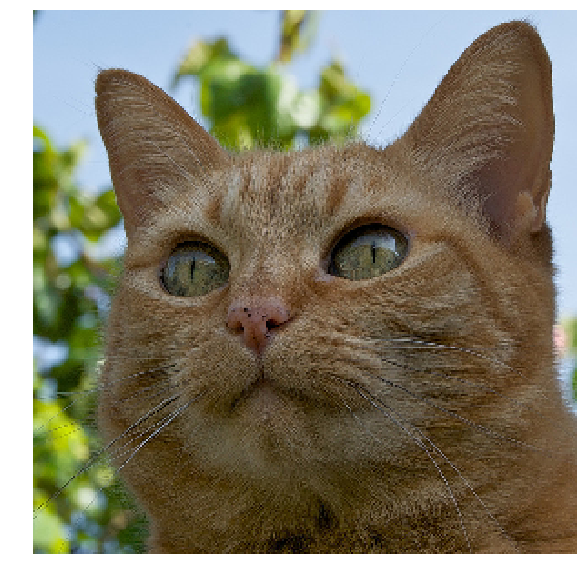

In [10]:
# easy example 524280
imgIds = coco.getImgIds(imgIds = [524280])
img_md = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
# img_md = coco.loadImgs(imgIds)

im, x = model.download_and_preprocess(img_md['coco_url'])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(im)

### Segmentation

quickshift(img_param, kernel_size=3, max_dist=200, ratio=0.2)
quickshift number of segments: 110
felzenszwalb(img_param, scale=100, sigma=2, min_size=50)
felzenszwalb number of segments: 97
slic(img_param, compactness=8)
slic number of segments: 55
watershed(img_param, markers=250, compactness=0.001)
watershed number of segments: 256
canny(img, sigma=1.8) - min_size=params['min_size']
canny number of segments: 205
morphological_geodesic_active_contour number of segments: 15


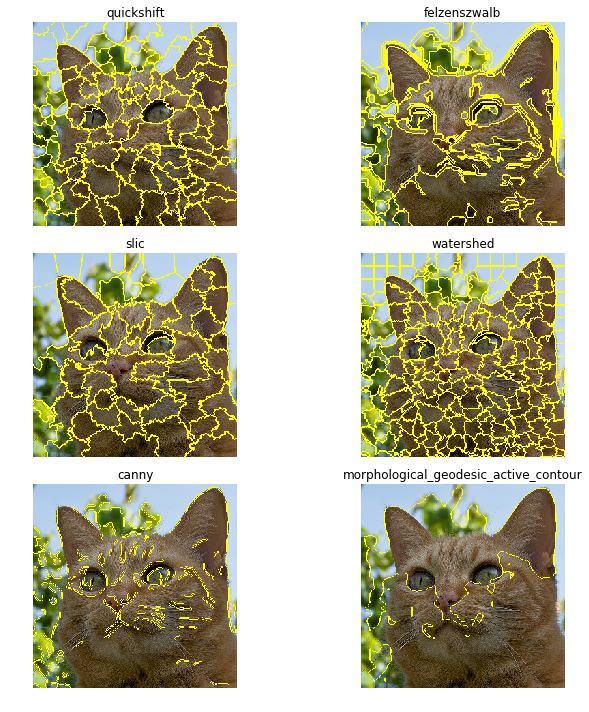

In [11]:
##### to-do: future refactoring -> add parameters to segmentation_fns dictionary. Check plot_segmentations method.
segmentation_fns = {
  'quickshift': {
      'kernel_size': 3,
      'max_dist': 200,
      'ratio': 0.2
  }, 
  'felzenszwalb': {
      'scale': 100,
      'sigma': 2,
      'min_size': 50,
  },
  'slic': {
#        'n_segments': 1000,
       'compactness': 8,
#        'sigma': 0.9
  },
  'watershed': {
      'markers': 250,
      'compactness': 0.001
  },
  'canny': {
      'min_size': 10,
      'sigma': 1.8
  },
  'morphological_geodesic_active_contour': {
      'iterations': 200,
      'smoothing': 1,
      'balloon' : -1,
      'threshold' : 0.8
  }
}

model.plot_segmentations([np.array(im)][0], segmentation_fns)

### Predictions

In [12]:
model.predict(x)

[('n02123045', 'tabby', 0.50437176),
 ('n02123159', 'tiger_cat', 0.21029814),
 ('n02123394', 'Persian_cat', 0.079715386),
 ('n02124075', 'Egyptian_cat', 0.034732353),
 ('n02127052', 'lynx', 0.01936864)]

### Explanations

100% |########################################################################|


Labels ['n02123045', 'tabby'] evaluation
IOU: 0.07795252682559513
DICE: 0.14463072331237697
Pixel acc: 0.6026554512813056


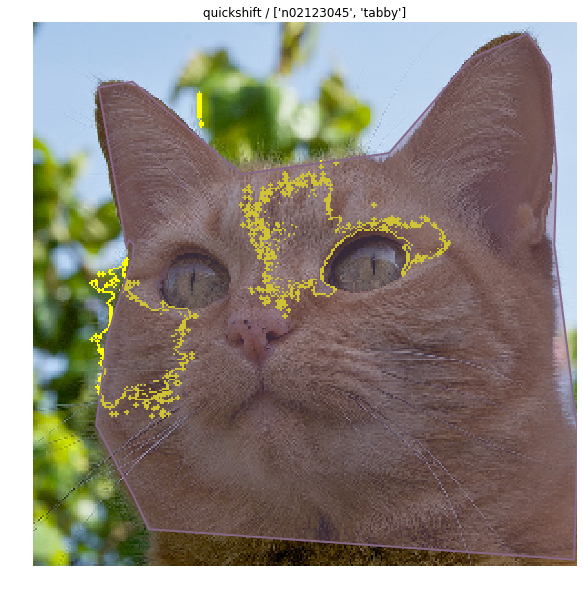

Labels ['n02123159', 'tiger_cat'] evaluation
IOU: 0.09106932014579305
DICE: 0.16693590125625382
Pixel acc: 0.5941432422456124


<Figure size 576x720 with 0 Axes>

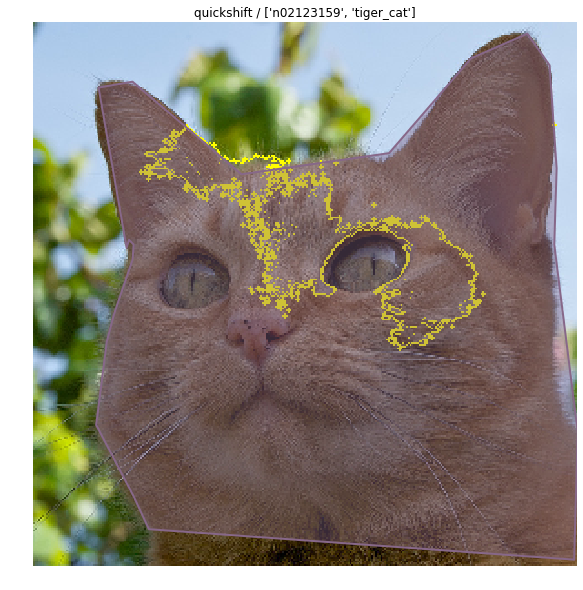

Labels ['n02123394', 'Persian_cat'] evaluation
IOU: 0.046335641368568964
DICE: 0.0885674529980908
Pixel acc: 0.6301048086710439


<Figure size 576x720 with 0 Axes>

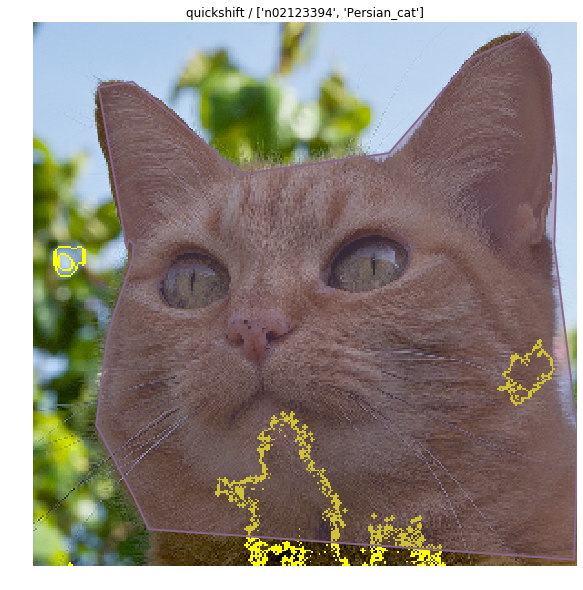

Labels ['n02124075', 'Egyptian_cat'] evaluation
IOU: 0.06442505133470226
DICE: 0.12105136243067277
Pixel acc: 0.6115703403765058


<Figure size 576x720 with 0 Axes>

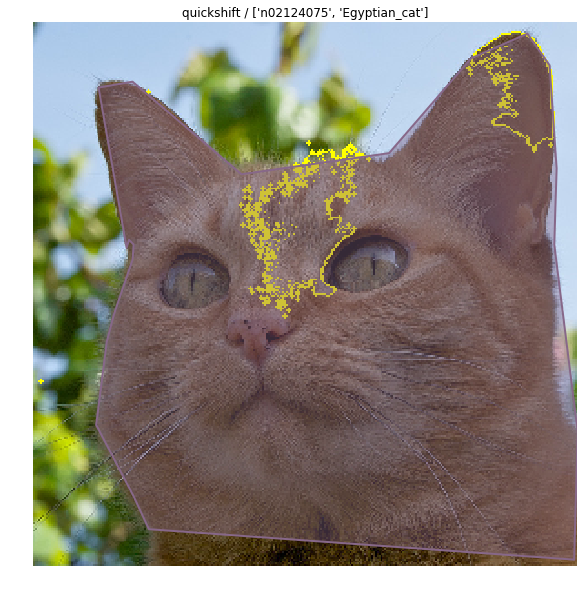

Labels ['n02127052', 'lynx'] evaluation
IOU: 3.399163805703797e-05
DICE: 6.798096532970769e-05
Pixel acc: 0.658113443921209


<Figure size 576x720 with 0 Axes>

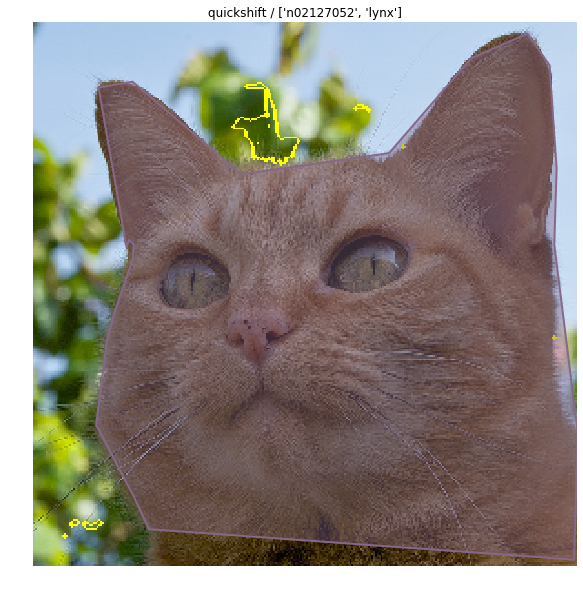

Segmentation quickshift union mask evaluation:
IOU: 0.19625592811381978
DICE: 0.3281169580881637
Pixel acc: 0.5402735987293207


<Figure size 576x720 with 0 Axes>

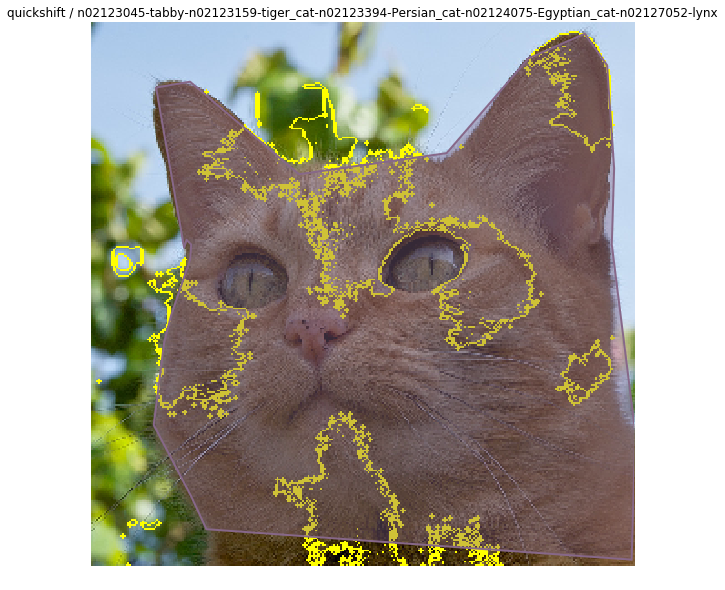

100% |########################################################################|


Labels ['n02123045', 'tabby'] evaluation
IOU: 0.003563169164882227
DICE: 0.007101036136763225
Pixel acc: 0.6506303061487008


<Figure size 576x720 with 0 Axes>

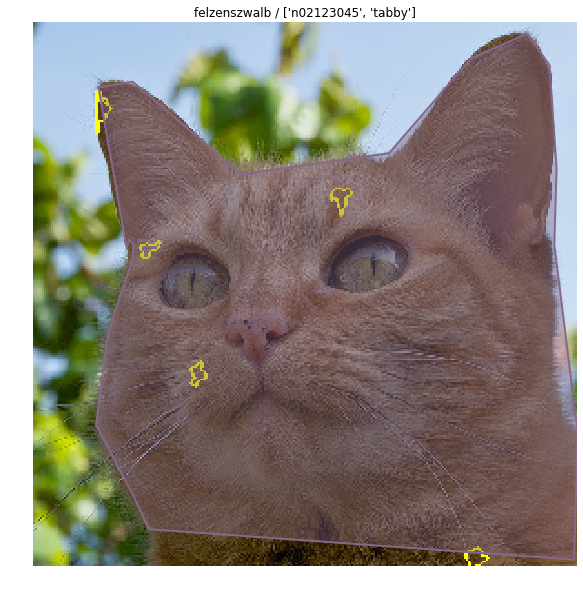

Labels ['n02123159', 'tiger_cat'] evaluation
IOU: 0.004673777199500094
DICE: 0.009304069252266376
Pixel acc: 0.6503059249896533


<Figure size 576x720 with 0 Axes>

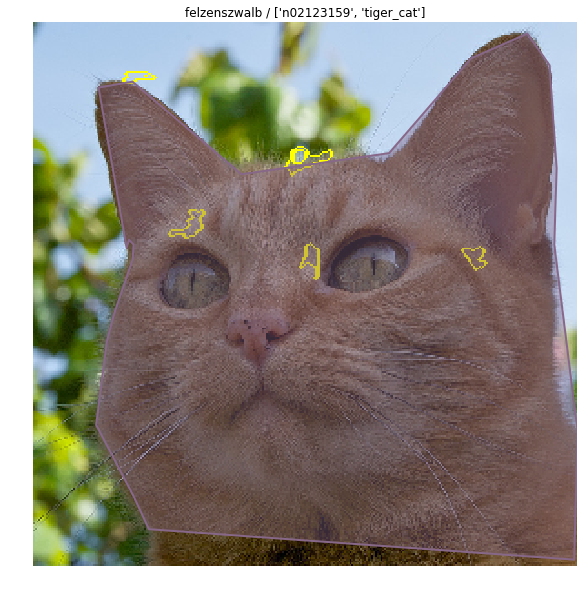

Labels ['n02123394', 'Persian_cat'] evaluation
IOU: 0.004215376738629576
DICE: 0.008395363855749296
Pixel acc: 0.6526548920034452


<Figure size 576x720 with 0 Axes>

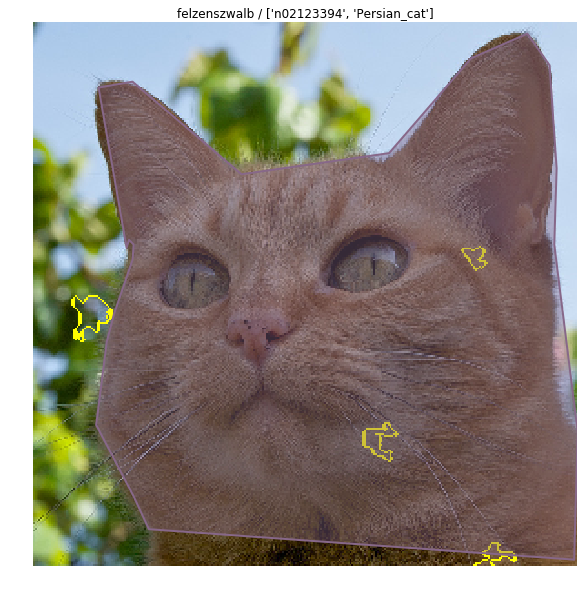

Labels ['n02124075', 'Egyptian_cat'] evaluation
IOU: 0.003441604027190384
DICE: 0.00685960002730189
Pixel acc: 0.6510218006509995


<Figure size 576x720 with 0 Axes>

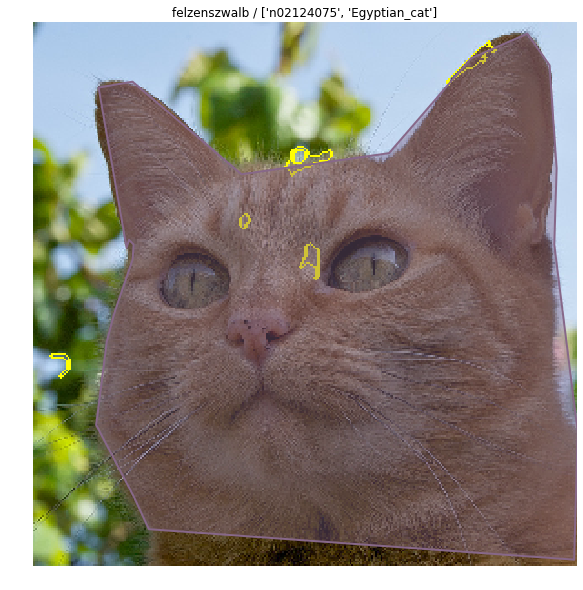

Labels ['n02127052', 'lynx'] evaluation
IOU: 0.004894494549312889
DICE: 0.00974131030841806
Pixel acc: 0.6504065950045301


<Figure size 576x720 with 0 Axes>

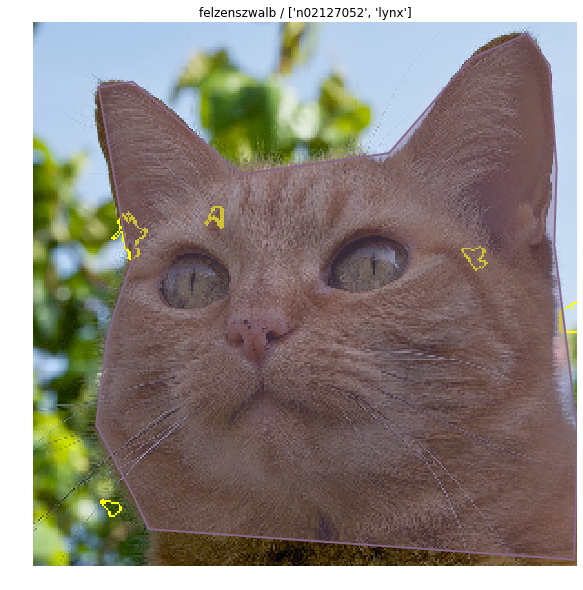

Segmentation felzenszwalb union mask evaluation:
IOU: 0.016302045381369576
DICE: 0.032081103163090055
Pixel acc: 0.649310410398094


<Figure size 576x720 with 0 Axes>

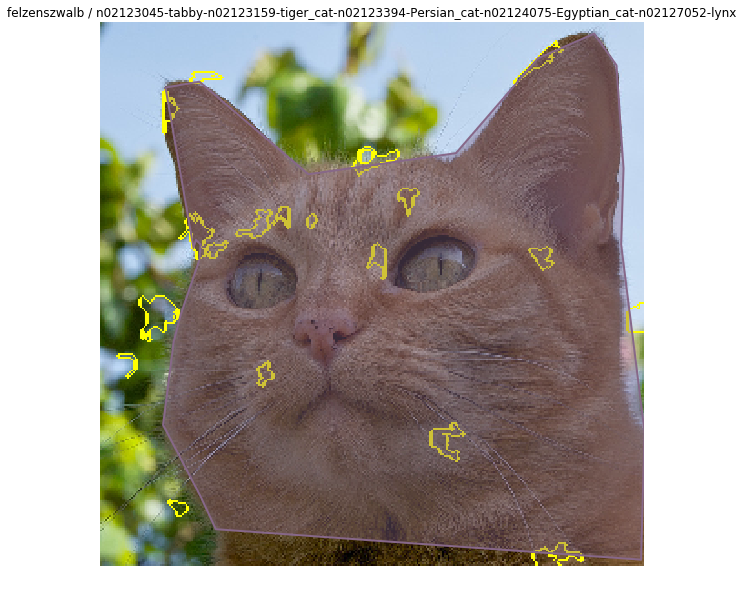

100% |########################################################################|


Labels ['n02123045', 'tabby'] evaluation
IOU: 0.29897370963979875
DICE: 0.4603229571485372
Pixel acc: 0.4706546906634154


<Figure size 576x720 with 0 Axes>

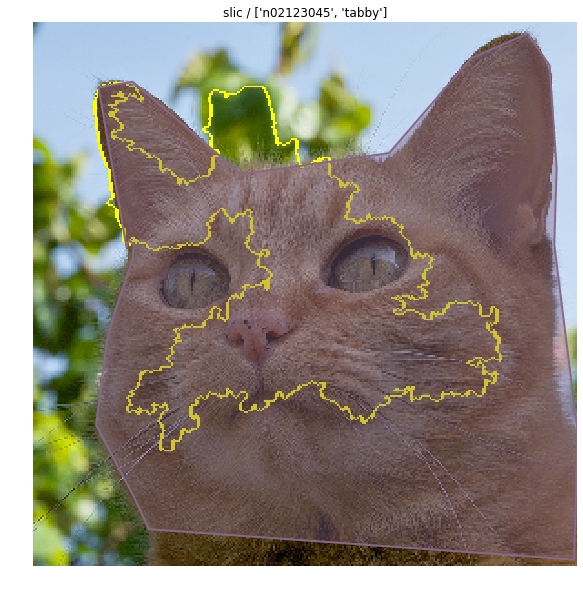

Labels ['n02123159', 'tiger_cat'] evaluation
IOU: 0.18089675313520015
DICE: 0.3063718359034041
Pixel acc: 0.5866601044731043


<Figure size 576x720 with 0 Axes>

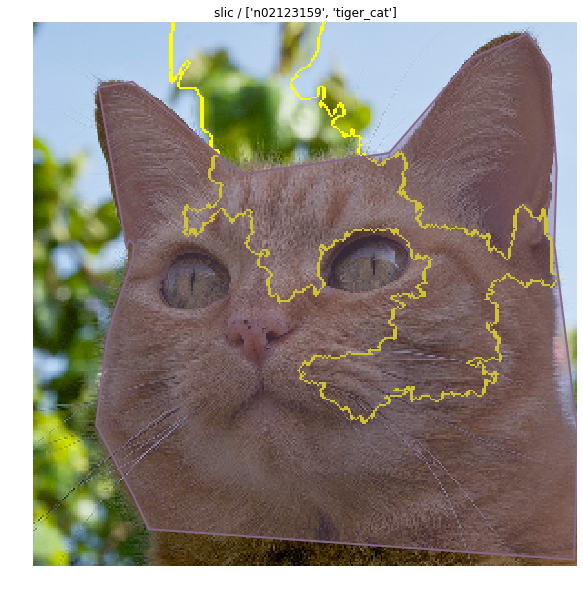

Labels ['n02123394', 'Persian_cat'] evaluation
IOU: 0.19238998339694982
DICE: 0.3226964098588921
Pixel acc: 0.5277681457701815


<Figure size 576x720 with 0 Axes>

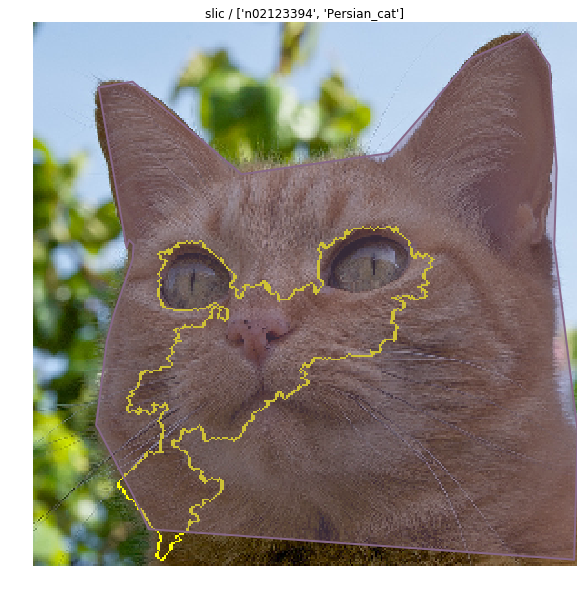

Labels ['n02124075', 'Egyptian_cat'] evaluation
IOU: 0.18547559040418182
DICE: 0.31291338582677164
Pixel acc: 0.5856310332099194


<Figure size 576x720 with 0 Axes>

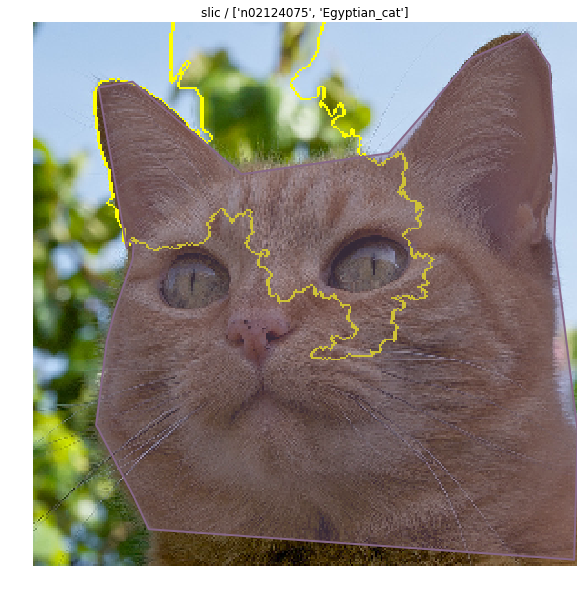

Labels ['n02127052', 'lynx'] evaluation
IOU: 0.14875685443668993
DICE: 0.25898753746219877
Pixel acc: 0.6112124025458329


<Figure size 576x720 with 0 Axes>

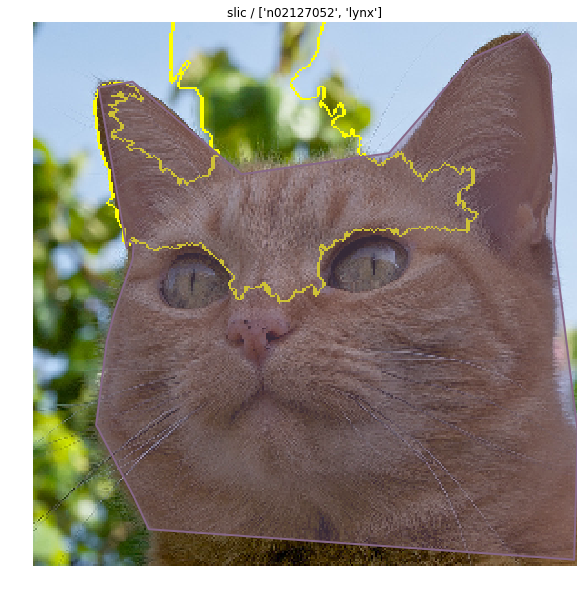

Segmentation slic union mask evaluation:
IOU: 0.44779571561626824
DICE: 0.6185896404944943
Pixel acc: 0.39790382657912104


<Figure size 576x720 with 0 Axes>

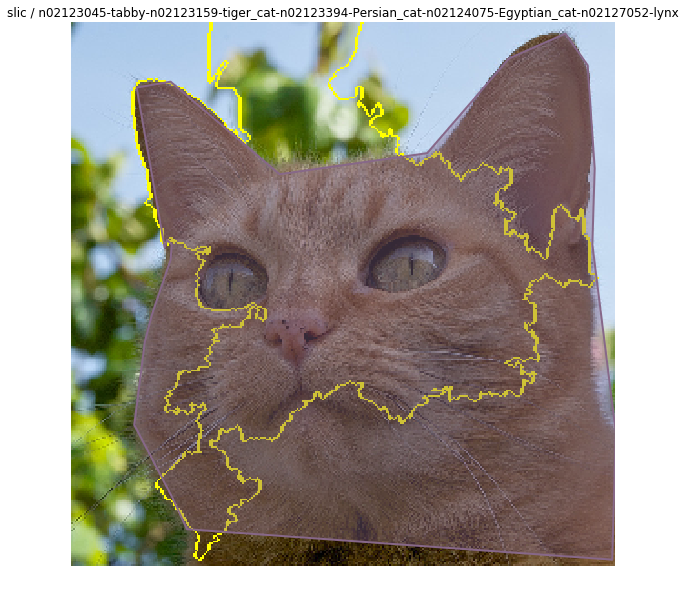

<Figure size 576x720 with 0 Axes>

In [16]:
# drop watershed for this test
segmentation_fns = {
  'quickshift': {
      'kernel_size': 3,
      'max_dist': 200,
      'ratio': 0.2
  }, 
  'felzenszwalb': {
      'scale': 100,
      'sigma': 2,
      'min_size': 50,
  },
  'slic': {
      'compactness': 8,
#       'n_segments': 1000,
#       'sigma': 0.9
  },
#   'watershed': {
#       'markers': 250,
#       'compactness': 0.001
#   },
#   'canny': { # to-do: not supported
#       'min_size': 10,
#       'sigma': 1.8
#   },
#   'morphological_geodesic_active_contour': { # to-do: not supported
#       'iterations': 200,
#       'smoothing': 1,
#       'balloon' : -1,
#       'threshold' : 0.8
#   }
}

results = model.explain(x[0], img_md, segmentation_fns)

# results is a dictionary containing masks and metrics per segmentation and labels.
# it includes also a union mask with its metrics.